In [2]:
import ot
import numpy as np
import cv2
import time
import matplotlib.pyplot as plt
from PIL import Image
import torch


In [ ]:
### GOOOD CPU between 2 images

def load_and_prep_image(path, size=(80, 80)):
    img = Image.open(path)
    
    if img.mode in ('RGBA', 'LA', 'P'):
        background = Image.new('RGB', img.size, (255, 255, 255)) # remove the transparent background if it's there
        if img.mode == 'P':
            img = img.convert('RGBA')
        background.paste(img, mask=img.split()[-1])
        img = background
    
    img = img.convert('L')
    img = img.resize(size)
    img_array = np.array(img, dtype=np.float64)
    
    img_array = img_array.max() - img_array
    
    threshold = 0.02 * img_array.max()
    img_array[img_array < threshold] = 0
    
    # Add epsilon
    img_array += 1e-6
    
    return img_array


def ot_interpolate(img1, img2, t, reg=0.004):
    size = img1.shape[0]
    
    d1 = img1 / np.sum(img1)
    d2 = img2 / np.sum(img2)
    
    d1_flat = d1.flatten()
    d2_flat = d2.flatten()
    
    A = np.vstack((d1_flat, d2_flat)).T
    
    x = np.arange(size, dtype=np.float64)
    y = np.arange(size, dtype=np.float64)
    X, Y = np.meshgrid(x, y)
    coords = np.stack((X.flatten(), Y.flatten()), axis=1)
    
    M = ot.dist(coords, coords, metric='sqeuclidean')
    M = M / M.max()
    
    weights = np.array([1 - t, t])
    barycenter_flat = ot.bregman.barycenter(A, M, reg, weights)
    
    result = barycenter_flat.reshape((size, size))
    
    return result


def save_ot_image(img_array, output_path):
    if img_array.max() > 0:
        img_array = img_array / img_array.max()
    
    img_array = 1.0 - img_array

    if img_array.max() > img_array.min():
        img_normalized = (img_array - img_array.min()) / (img_array.max() - img_array.min())
        img_normalized = (img_normalized * 255).astype(np.uint8)
    else:
        img_normalized = np.zeros_like(img_array, dtype=np.uint8)
    
    img_pil = Image.fromarray(img_normalized, mode='L')
    img_pil.save(output_path)


img1 = load_and_prep_image("walking/frame0023.png", size=(160, 120))
img2 = load_and_prep_image("jogging/frame0029.png", size=(160, 120))

t = 0
i = 1
while t < 1:
    result = ot_interpolate(img1, img2, t=t, reg=0.0001)
    save_ot_image(result, f"output/frame{i:04}.png")
    t += .05
    i +=1

After loading - min: 34.0, max: 255.0, mean: 213.33286458333333
Inverting (bright background)
After invert - min: 0.0, max: 221.0
After loading - min: 23.0, max: 255.0, mean: 213.7778125
Inverting (bright background)
After invert - min: 0.0, max: 232.0


ValueError: operands could not be broadcast together with shapes (2,19200) (14400,) 

In [ ]:
### GOOD GPU

import torch
import ot
import numpy as np
from PIL import Image
import os
import glob

WIDTH = 160
HEIGHT = 120
REG_VAL = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on: {device}")

def load_image_gpu(path, size=(WIDTH, HEIGHT)):
    img = Image.open(path).convert('RGBA')
    
    bg = Image.new('RGBA', img.size, (255, 255, 255))
    img = Image.alpha_composite(bg, img).convert('L')
    img = img.resize(size)
    
    img_array = np.array(img, dtype=np.float64)
    t_img = torch.tensor(img_array, dtype=torch.float64, device=device)
    
    t_img = t_img.max() - t_img
        
    t_img[t_img < 0.05 * t_img.max()] = 0
    
    t_img = t_img / torch.sum(t_img)
    
    return t_img.flatten()

def get_cost_matrix_gpu(width, height):
    x = torch.arange(width, dtype=torch.float64, device=device)
    y = torch.arange(height, dtype=torch.float64, device=device)
    
    Y, X = torch.meshgrid(y, x, indexing='ij') 
    
    coords = torch.stack((X.flatten(), Y.flatten()), dim=1)
    
    M = torch.cdist(coords, coords, p=2) ** 2
    M = M / M.max()
    return M

def save_ot_image_gpu(tensor, output_path, size=(WIDTH, HEIGHT)):
    arr = tensor.cpu().numpy().reshape(size[1], size[0]) # reshape(Height, Width)
    
    if arr.max() > 0:
        arr = arr / arr.max()
        
    arr = 1.0 - arr
    
    arr = (arr * 255).clip(0, 255).astype(np.uint8)
    
    Image.fromarray(arr).save(output_path)

M_gpu = get_cost_matrix_gpu(WIDTH, HEIGHT)

os.makedirs("output_gpu", exist_ok=True)

start_frame = 30
t = .05

for i in range(1, 21):
    
    t = .05 * i
    
    path1 = f"walking/frame{i:04d}.png"
    path2 = f"jogging/frame{i:04d}.png"
    
    d1 = load_image_gpu(path1, size=(WIDTH, HEIGHT))
    d2 = load_image_gpu(path2, size=(WIDTH, HEIGHT))
    
    A_gpu = torch.stack((d1, d2), dim=1)

    weights = torch.tensor([1 - t, t], dtype=torch.float64, device=device)
    barycenter = ot.bregman.barycenter(A_gpu, M_gpu, REG_VAL, weights)
    
    save_ot_image_gpu(barycenter, f"output_gpu/out_{i:04d}.png", size=(WIDTH, HEIGHT))

Running on: cuda
Pre-computing 160x120 geometry...
Computing massive cost matrix... (This may take 5-10 seconds)
Starting render...


AttributeError: 'Tensor' object has no attribute 'lower'

In [ ]:
# CONV 2D Gemini from scratch

import numpy as np
from scipy.ndimage import gaussian_filter
from PIL import Image
import os

class ConvolutionalBarycenter:
    def __init__(self, size, sigma=2.0, iterations=15):
        """
        size: (Height, Width)
        sigma: The 'blur' radius. Higher = smoother/more stable. Lower = sharper/unstable.
               sigma=2.0 is a good starting point for 160x120 images.
        iterations: 10-20 is usually enough.
        """
        self.height, self.width = size
        self.sigma = sigma
        self.iters = iterations
        self.epsilon = 1e-10 # Tiny number to prevent division by zero

    def solve(self, images, weights):
        """
        images: List of 2D numpy arrays (normalized).
        weights: List of floats (sum to 1.0).
        """
        # 1. Initialize Dual Variables (v)
        # We have one 'v' map per image. Initialize to 1.0.
        # Shape: (Num_Images, Height, Width)
        v = np.ones((len(images), self.height, self.width), dtype=np.float64)
        
        # 2. The Main Loop (Sinkhorn Iterations)
        barycenter = None
        
        for i in range(self.iters):
            barycenter_accum = np.ones((self.height, self.width), dtype=np.float64)
            
            # --- Step A: Project to Barycenter ---
            for k in range(len(images)):
                # Blur the current dual variable v[k]
                Kv = gaussian_filter(v[k], sigma=self.sigma, mode='constant', cval=0.0)
                
                # Add to the geometric mean accumulator
                # b = product( (Kv)^weight )
                # We use log-domain for numerical stability if needed, but power rule is faster here
                barycenter_accum *= (Kv + self.epsilon) ** weights[k]

            barycenter = barycenter_accum

            # --- Step B: Update Dual Variables ---
            for k in range(len(images)):
                # We want to transport the Barycenter 'b' to Image 'k'.
                # The error is Image[k] / Blur(barycenter)
                # But we must divide out the previous contribution (K * v[k]) to avoid feedback loops?
                # A simpler stable update is: v[k] = v[k] * Image[k] / Blur(barycenter * v[k])
                # BUT the standard Solomon 2015 update is simpler:
                
                Kb = gaussian_filter(barycenter, sigma=self.sigma, mode='constant', cval=0.0)
                v[k] = images[k] / (Kb + self.epsilon)

        return barycenter

# --- 2. IMAGE PREP (Robust) ---
def load_image(path, size):
    img = Image.open(path).convert("RGBA")
    bg = Image.new("RGBA", img.size, (255, 255, 255, 255))
    img = Image.alpha_composite(bg, img).convert("L")
    img = img.resize((size[1], size[0])) # PIL is (Width, Height)
    
    arr = np.array(img, dtype=np.float64)


    
    # Invert (Black ink -> White Mass)
    if arr.mean() > 127:
        arr = arr.max() - arr
    
    arr = gaussian_filter(arr, sigma=1.0) 

    # Denoise
    arr[arr < 0.05 * arr.max()] = 0

    
    # Normalize
    arr += 1e-9
    arr /= arr.sum()
    return arr

def save_image(arr, path):
    if arr.max() > 0: arr /= arr.max()
    arr = 1.0 - arr
    img = Image.fromarray((arr * 255).astype(np.uint8))
    img.save(path)

# --- 3. MAIN EXECUTION ---

# Settings
H, W = 120, 160  # Height, Width
SIGMA = .8      # Try 1.0 (sharp) to 3.0 (blurry)
solver = ConvolutionalBarycenter(size=(H, W), sigma=SIGMA, iterations=100)

os.makedirs("output_custom", exist_ok=True)

# Generate
print("Starting Custom Solver...")
frame_count = 30
t = 0.0

# Using dummy loop for demonstration, replace with your file loop
while t <= 1.0:
    # Replace these with your f"walking/frame..." paths
    # Ensure you are loading the SAME frame index if morphing pose-to-pose
    path1 = f"walking/frame{frame_count:04d}.png"
    path2 = f"jogging/frame{frame_count:04d}.png"
    
    # Basic check to skip missing files
    if not os.path.exists(path1): break

    img1 = load_image(path1, (H, W))
    img2 = load_image(path2, (H, W))
    
    # Run the solver
    # Note: You pass a LIST of images and a LIST of weights
    result = solver.solve([img1, img2], weights=[1-t, t])
    
    save_image(result, f"output_custom/frame{frame_count:04d}.png")
    print(f"Frame {frame_count} (t={t:.2f})")
    
    t += 0.05
    frame_count += 1

print("Done.")

Starting Custom Solver...
Frame 30 (t=0.00)
Frame 31 (t=0.05)
Frame 32 (t=0.10)
Frame 33 (t=0.15)
Frame 34 (t=0.20)
Frame 35 (t=0.25)
Frame 36 (t=0.30)
Frame 37 (t=0.35)
Frame 38 (t=0.40)
Frame 39 (t=0.45)
Frame 40 (t=0.50)
Frame 41 (t=0.55)
Frame 42 (t=0.60)
Frame 43 (t=0.65)
Frame 44 (t=0.70)
Frame 45 (t=0.75)
Frame 46 (t=0.80)
Frame 47 (t=0.85)
Frame 48 (t=0.90)
Frame 49 (t=0.95)
Done.


In [43]:
# LINEAR

import numpy as np
from PIL import Image
import os

# --- SETTINGS ---
SIZE = (160, 120) # Match your OT dimensions

def load_image_linear(path):
    """
    Simple loader: Grayscale, Resize, Normalize 0-1.
    No need for 'mass' or 'inversion' logic here, standard blending works on pixel values.
    """
    try:
        img = Image.open(path).convert("RGBA")
        
        # Handle Transparency (Paste on White)
        bg = Image.new("RGBA", img.size, (255, 255, 255, 255))
        img = Image.alpha_composite(bg, img).convert("L")
        img = img.resize(SIZE)
        
        # Convert to float 0.0 - 1.0
        arr = np.array(img, dtype=np.float64) / 255.0
        return arr
    except Exception:
        return None

def save_frame(arr, path):
    # Convert back to 0-255 uint8
    arr = np.clip(arr * 255.0, 0, 255).astype(np.uint8)
    Image.fromarray(arr).save(path)

# --- MAIN EXECUTION ---
os.makedirs("output_linear", exist_ok=True)
print("Starting Linear Cross-Dissolve...")

# Assuming you have 30 frames roughly
t = 0
for i in range(30, 50):
    path1 = f"walking/frame{i:04d}.png"
    path2 = f"jogging/frame{i:04d}.png"
    
    if not os.path.exists(path1): break
    
    img1 = load_image_linear(path1)
    img2 = load_image_linear(path2)
    
    # --- THE ALGORITHM ---
    # t moves from 0 to 1 as the video progresses
    # This creates a blend based on the frame number itself
    # Or you can fix t=0.5 to see the static "Ghost" effect
    t += .05
    
    # Linear Interpolation Formula:
    # Result = (1-t)*ImageA + (t)*ImageB
    result = (1 - t) * img1 + t * img2
    
    save_frame(result, f"output_linear/frame{i:04d}.png")
    
    if i % 5 == 0: print(f"Frame {i} done")

print("Done. Check 'output_linear' folder.")



Starting Linear Cross-Dissolve...
Frame 30 done
Frame 35 done
Frame 40 done
Frame 45 done
Done. Check 'output_linear' folder.


Computing Sinkhorn Plan...


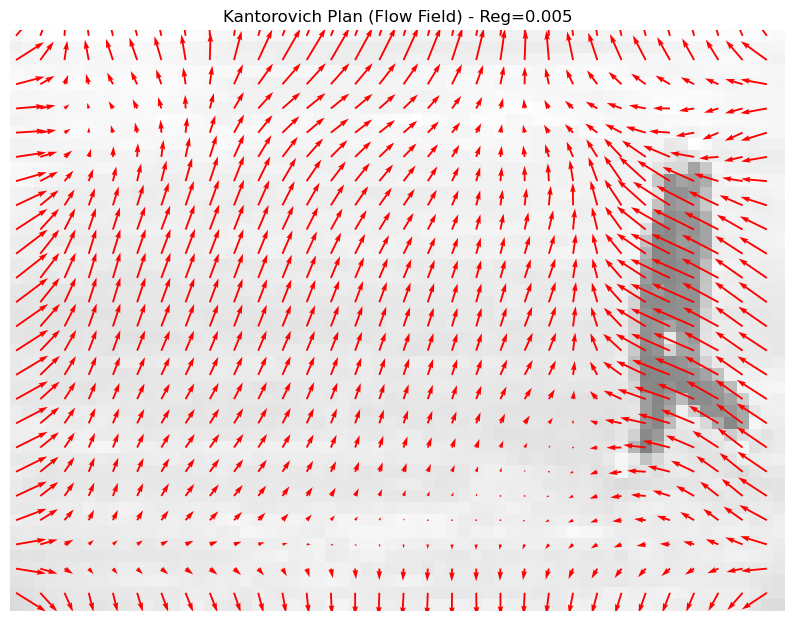

In [6]:
import numpy as np
import ot
import matplotlib.pyplot as plt
from PIL import Image

# --- CONFIG ---
# We use a smaller size for the PLAN visualization because 
# calculating the plan for 160x120 is extremely heavy on RAM (3GB+).
# 50x50 is large enough to see the motion but fast to compute.
VIS_SIZE = (64, 48) 
REG = 0.005

def load_image_for_plan(path, size):
    img = Image.open(path).convert('L').resize(size)
    data = np.array(img, dtype=np.float64)
    
    # Invert & Normalize
    if data.mean() > 127: data = data.max() - data
    data += 1e-9
    data /= data.sum()
    return data

# 1. Load Images
img1 = load_image_for_plan("walking/frame0023.png", VIS_SIZE)
img2 = load_image_for_plan("jogging/frame0029.png", VIS_SIZE)

# 2. Compute Geometry (Cost Matrix M)
# Coordinates
y, x = np.mgrid[0:VIS_SIZE[1], 0:VIS_SIZE[0]]
coords = np.stack((y.flatten(), x.flatten()), axis=1)

# Distance Matrix
M = ot.dist(coords, coords, metric='sqeuclidean')
M = M.astype(np.float64)
M /= M.max()

# 3. Compute Kantorovich Plan (Gamma)
print("Computing Sinkhorn Plan...")
# ot.sinkhorn returns the Transport Matrix (N x N), NOT the image.
gamma = ot.sinkhorn(img1.flatten(), img2.flatten(), M, REG)

# 4. Visualization: Displacement Field
# We calculate where mass 'moves' on average.
# Displacement = (TargetCoords * Plan) / Mass
# This turns the N x N matrix into an N x 2 vector field.

# Target coordinates matrix
coords_target = coords 

# Compute center of mass movement for each source pixel
# (Where does pixel 'i' send its mass on average?)
# We use matrix multiplication: Gamma @ Coords
transported_coords = gamma @ coords_target 
# Normalize by the mass at that pixel to get the average position
with np.errstate(divide='ignore', invalid='ignore'):
    transported_coords /= img1.flatten()[:, None]

# If a pixel has 0 mass, it goes nowhere (fix NaNs)
transported_coords[np.isnan(transported_coords)] = coords[np.isnan(transported_coords)]

# Vectors = End_Pos - Start_Pos
flow = transported_coords - coords

# Reshape for plotting
Fy = flow[:, 0].reshape(VIS_SIZE[1], VIS_SIZE[0])
Fx = flow[:, 1].reshape(VIS_SIZE[1], VIS_SIZE[0])

# 5. Plotting
plt.figure(figsize=(10, 8))
plt.imshow(img1, cmap='gray_r', alpha=0.5)
plt.title(f"Kantorovich Plan (Flow Field) - Reg={REG}")

# Downsample arrows for readability (show every 2nd arrow)
step = 2
Y, X = np.mgrid[0:VIS_SIZE[1], 0:VIS_SIZE[0]]
plt.quiver(X[::step, ::step], Y[::step, ::step], 
           Fx[::step, ::step], -Fy[::step, ::step], # Negative Y for image coords
           color='red', scale=1, scale_units='xy', angles='xy')

plt.axis('off')
plt.show()